In [1]:
import numpy as np
from scipy.interpolate import CubicSpline, Akima1DInterpolator, PchipInterpolator, interp1d
from scipy.spatial.transform import Rotation as R
from scipy.spatial.transform import RotationSpline

import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline
%config InlineBackend.figure_format='retina'
np.set_printoptions(suppress = True, precision = 6)
import matplotlib
# matplotlib.interactive(False)

In [2]:
from collections import namedtuple

constants_dict = {
    'WGS84_RADIUS' : 6378137.0,
    'WGS84_ECCENTRICITY' : 0.0818191908425,
    'WGS84_GM' : 3.986005e14,
    'WGS84_J2' : 1.082627E-3,
    'WGS84_POLAR_RADIUS': 6356752.31425,
    'WGS84_FLATTENING': 1.0 / 298.257223563,
    'EARTH_ROTATION_RATE' : 7.2921151467e-5,
}

Constants = namedtuple('Constants', sorted(constants_dict))
constants = Constants(**constants_dict)

def radii_of_curvature(latitude):
    E = constants.WGS84_ECCENTRICITY
    x = 1.0 - (E * np.sin(latitude))**2
    R_e = constants.WGS84_RADIUS / np.sqrt(x)
    R_n = R_e * (1.0 - E**2) / x
    return R_n, R_e

def cart2curv(lat, h):
    R_N, R_E = radii_of_curvature(lat)
    rn, re = R_N + h, R_E + h
    return np.array([[1.0/rn, 0.0, 0.0], [0.0, 1.0 / (re * np.cos(lat)), 0.0], [0., 0., -1.]])

def curv2cart(lat, h):
    R_N, R_E = radii_of_curvature(lat)
    rn, re = R_N + h, R_E + h
    return np.array([[rn, 0.0, 0.0], [0.0, (re * np.cos(lat)), 0.0], [0., 0., -1.]])

def skew(phi):
    '''eq. (7.10)'''
    e1, e2, e3 = np.squeeze(phi)
    return np.array([[0., -e3, e2],
                     [e3, 0., -e1],
                     [-e2, e1, 0.]])

def get_omega_ie_n(latitude):
    omega_ie_n = np.zeros((latitude.shape[0], 3))
    omega_ie_n[:, 0] = np.cos(latitude) * constants.EARTH_ROTATION_RATE
    omega_ie_n[:, 2] = -np.sin(latitude) * constants.EARTH_ROTATION_RATE
    return omega_ie_n

def get_omega_en_n(velocity_ned, latitude, height):
    R_n, R_e = radii_of_curvature(latitude)
    omega_en_n = np.zeros(velocity_ned.shape)
    omega_en_n[:, 0] = velocity_ned[:, 1] / (R_e + height)
    omega_en_n[:, 1] = -velocity_ned[:, 0] / (R_n + height)
    omega_en_n[:, 2] = -velocity_ned[:, 1] * np.tan(latitude) / (R_e + height)
    return omega_en_n

def gravity_ned(latitude, h):
    R_0 = constants.WGS84_RADIUS;
    R_P = constants.WGS84_POLAR_RADIUS;
    e = constants.WGS84_ECCENTRICITY;
    f = constants.WGS84_FLATTENING;
    mu = constants.WGS84_GM;
    omega_ie = constants.EARTH_ROTATION_RATE;
    
    sinsqL = np.sin(latitude) ** 2
    g_0 = 9.7803253359 * (1 + 0.001931853 * sinsqL) / np.sqrt(1.0 - e * e * sinsqL)
    
    gn = -8.08e-9 * h * np.sin(2 * latitude)
    gd = g_0 * (1. - (2. / R_0) * (1. + f * (1. - 2. * sinsqL) + (omega_ie * omega_ie * R_0 * R_0 * R_P / mu)) * h + (3. * h * h / (R_0 * R_0)))
    
    return np.array([gn, 0.0, gd])

In [3]:
def triads(velocities):
    vel_global = np.array(velocities) / np.linalg.norm(velocities, axis = 1).reshape((-1, 1))
    vel_local = np.zeros(vel_global.shape)
    vel_local[:, 0] = 1.0
    
    angle = np.arcsin(vel_global[:, 2])
    
    gravity_global = np.zeros(vel_global.shape)
    gravity_global[:, 2] = 1.0
    gravity_local = np.zeros(vel_global.shape)
    gravity_local[:, 0] = np.sin(angle)
    gravity_local[:, 2] = np.cos(angle)
    
    second_global = np.cross(vel_global, gravity_global)
    second_local = np.cross(vel_local, gravity_local)
    
    third_global = np.cross(vel_global, second_global)
    third_local = np.cross(vel_local, second_local)
    
    FROM = np.zeros((len(vel_global), 3, 3))
    FROM[:, :, 0] = vel_local
    FROM[:, :, 1] = second_local
    FROM[:, :, 2] = third_local
    TO = np.zeros((len(vel_global), 3, 3))
    TO[:, :, 0] = vel_global
    TO[:, :, 1] = second_global
    TO[:, :, 2] = third_global
    
    A = np.matmul(TO, FROM)
    
#     vel_global = np.array(velocities) / np.linalg.norm(velocities, axis = 1).reshape((-1, 1))
#     pitch = np.arcsin(vel_global[:, 2])
#     yaw = np.arctan2(vel_global[:, 1], vel_global[:, 0])
#     angles = np.zeros(vel_global.shape)
#     angles[:, 0] = yaw
#     angles[:, 1] = pitch
#     return R.from_euler('zyx', angles).as_matrix()
    
    return A

class Simulation:
    def __init__(self, timepoints, position_points, dt = 0.01, in_convention = 'enu', out_convention='enu'):
        self.timepoints = timepoints
        enu2ned = ned2enu = np.array([[0, 1, 0], [1, 0, 0], [0, 0, -1.]])
        if in_convention != out_convention:
            if in_convention == 'enu':
                self.position_points = np.dot(position_points, enu2ned)
            if in_convention == 'ned':
                self.position_points = np.dot(position_points, ned2enu)
        else:
            self.position_points = position_points
        
        self.timepoints = timepoints
        self.position_points = position_points
        
        self.times = np.arange(timepoints[0], timepoints[-1] + dt, dt)
        self.dt = dt
        self.convention = out_convention
        self.__buildSplines()
        self.__generateData()
        
    def __buildSplines(self):
        self.positions_spline = CubicSpline(self.timepoints, self.position_points, bc_type='clamped')
        self.velocities_spline = self.positions_spline.derivative()
        self.accelerations_spline = self.velocities_spline.derivative()
        
    def __generateData(self):
        # enu or ned positions, velocities and accelerations
        self.positions = self.positions_spline(self.times)
        self.velocities = self.velocities_spline(self.times)
        # body-to-ned or body-to-enu rotations
        self.body2conventionRotations = self.generateRotations()
        
    def generateRotations(self):
        from_orientations = np.zeros(self.velocities.shape)
        from_orientations[:, 0] = 1.0
        
        # vehicle motion direction
        to_orientations =\
            self.velocities / np.linalg.norm(self.velocities, axis=1).reshape(-1,1)
        
        axis = np.cross(from_orientations, to_orientations)
        for i, ax in enumerate(axis):
            norm = np.linalg.norm(ax)
            if norm > 1e-10:
                axis[i] = ax / norm
        angles = np.arccos(np.sum(from_orientations * to_orientations, axis=1))
        rotvecs = axis * angles.reshape((-1, 1))
        # to overcome unknown orientation at start and end
        rotvecs[0], rotvecs[-1] = rotvecs[1], rotvecs[-2]
        body2conventionRotations = R.from_rotvec(rotvecs)
        
        
#         orientations = triads(self.velocities)
#         orientations[0] = orientations[1]
#         orientations[-1] = orientations[-2]
#         body2conventionRotations = R.from_matrix(orientations)
        
        return body2conventionRotations
    
    def data(self):
        return {'convention': self.convention,
                'times': self.times,
                'dt': self.dt,
                self.convention + '_positions': self.positions,
                self.convention + '_velocities': self.velocities,
                'body2' + self.convention + '_rotations': self.body2conventionRotations,
                'n_records': len(self.times)}
    
    
class EarthInducedKinematics:
    def __init__(self, lat_deg, lon_deg, h, simdata):
        self.lat_start = np.deg2rad(lat_deg)
        self.lon_start = np.deg2rad(lon_deg)
        self.h_start = h
        self.data = simdata
        assert simdata['convention'] == 'ned', "Input data should be resolved w.r.t NED"
        
    def updateSimulatedData(self):
        self.data['geodetic_positions'] = np.zeros((self.data['n_records'], 3))
        
        old_pos_ned = self.data['ned_positions'][0]
        self.data['geodetic_positions'][0] = cart2curv(self.lat_start, self.h_start) @ old_pos_ned\
            + np.array([self.lat_start, self.lon_start, self.h_start])
        for i in range(1, self.data['n_records']):
                llh_prev = self.data['geodetic_positions'][i-1]
                pos_ned_prev = self.data['ned_positions'][i-1]
                pos_ned = self.data['ned_positions'][i]
                self.data['geodetic_positions'][i] = cart2curv(llh_prev[0], llh_prev[2])\
                    @ (pos_ned - pos_ned_prev) + llh_prev
            
        self.data['body_angular_rates_with_earth'] = np.zeros((self.data['n_records'], 3))
        self.data['body_accelerations_with_earth'] = np.zeros((self.data['n_records'], 3))
        old_C_b_n_values = self.data['body2ned_rotations'][0:-1].as_matrix()
        C_b_n_values = self.data['body2ned_rotations'][1:].as_matrix()
        for i in range(1, self.data['n_records']):
            old_lat, _, old_h = self.data['geodetic_positions'][i-1]
            lat, _, h = self.data['geodetic_positions'][i]
            old_C_b_n = old_C_b_n_values[i-1]
            C_b_n = C_b_n_values[i-1]
            old_v_eb_n = self.data['ned_velocities'][i-1]
            v_eb_n = self.data['ned_velocities'][i]
            omega_ie_n = get_omega_ie_n(np.array([[old_lat]]))
            old_omega_en_n = get_omega_en_n(old_v_eb_n.reshape((1, 3)), old_lat, old_h)
            omega_en_n = get_omega_en_n(v_eb_n.reshape((1, 3)), lat, h)
            
            
            if i == 1:
                R_old_new = np.eye(3) - skew(omega_ie_n
                    + 0.5 * omega_en_n + 0.5 * old_omega_en_n) * self.data['dt']
                a = np.array([0.5 * (R_old_new[1, 2] - R_old_new[2, 1]),
                              0.5 * (R_old_new[2, 0] - R_old_new[0, 2]),
                              0.5 * (R_old_new[0, 1] - R_old_new[1, 0])])
                tmp = np.arccos(0.5 * (R_old_new[0, 0] + R_old_new[1, 1] + R_old_new[2, 2] - 1.0))
                if tmp > 1e-20:
                    a = a * tmp / np.sin(tmp)
                self.data['body_angular_rates_with_earth'][0] = a / self.data['dt']
                
                f_ib_n = (old_v_eb_n - np.array([0., 0., 0.])) / self.data['dt']\
                    - gravity_ned(old_lat, old_h)\
                    + skew(old_omega_en_n + 2 * omega_ie_n) @ old_v_eb_n
                mag_alpha = np.linalg.norm(a)
                Alpha_ib_b = skew(a)
                if mag_alpha > 1e-8:
                    ave_C_b_b = np.eye(3)\
                      + (1.0 - np.cos(mag_alpha)) * Alpha_ib_b / mag_alpha**2\
                      + (1.0 - np.sin(mag_alpha) / mag_alpha) * Alpha_ib_b @ Alpha_ib_b / mag_alpha**2
                else:
                    ave_C_b_b = np.eye(3)
                ave_C_b_n = old_C_b_n @ ave_C_b_b - 0.5 * skew(old_omega_en_n + omega_ie_n) @ old_C_b_n
                f_ib_b = np.linalg.inv(ave_C_b_n) @ f_ib_n
                self.data['body_accelerations_with_earth'][0] = f_ib_b
                
            
            # angular velocity in body frame
            R_old_new = C_b_n.T @ (np.eye(3) - skew(omega_ie_n
                + 0.5 * omega_en_n + 0.5 * old_omega_en_n) * self.data['dt']) @ old_C_b_n
            a = np.array([0.5 * (R_old_new[1, 2] - R_old_new[2, 1]),
                          0.5 * (R_old_new[2, 0] - R_old_new[0, 2]),
                          0.5 * (R_old_new[0, 1] - R_old_new[1, 0])])
            tmp = np.arccos(0.5 * (R_old_new[0, 0] + R_old_new[1, 1] + R_old_new[2, 2] - 1.0))
            if tmp > 1e-20:
                a = a * tmp / np.sin(tmp)
            self.data['body_angular_rates_with_earth'][i] = a / self.data['dt']#  + np.random.normal(0.0, np.deg2rad(0.01), size=3) + np.deg2rad([0.0, 0.0, 0.01])
            
            # accelerations
            f_ib_n = (v_eb_n - old_v_eb_n) / self.data['dt']\
                - gravity_ned(old_lat, old_h)\
                + skew(old_omega_en_n + 2 * omega_ie_n) @ old_v_eb_n
            mag_alpha = np.linalg.norm(a)
            Alpha_ib_b = skew(a)
            if mag_alpha > 1e-20:
                ave_C_b_b = np.eye(3)\
                      + (1.0 - np.cos(mag_alpha)) * Alpha_ib_b / mag_alpha**2\
                      + (1.0 - np.sin(mag_alpha) / mag_alpha) * Alpha_ib_b @ Alpha_ib_b / mag_alpha**2
            else:
                ave_C_b_b = np.eye(3)
            ave_C_b_n = old_C_b_n @ ave_C_b_b - 0.5 * skew(old_omega_en_n + omega_ie_n) @ old_C_b_n
            f_ib_b = np.linalg.inv(ave_C_b_n) @ f_ib_n
            self.data['body_accelerations_with_earth'][i] = f_ib_b
            
        self.data['odometer'] = np.zeros(self.data['n_records'])
        for i, (R, v_n) in enumerate(zip(self.data['body2ned_rotations'].inv().as_matrix(),
                                         self.data['ned_velocities'])):
            self.data['odometer'][i] = (R @ v_n)[0]
        
        
#         omegas_ie_n = get_omega_ie_n(self.data['geodetic_positions'][:, 0])
#         omegas_en_n = get_omega_en_n(self.data['ned_velocities'],
#                                      self.data['geodetic_positions'][:, 0],
#                                      self.data['geodetic_positions'][:, 2])
                
def generate_ned_points_from_lonlat_sequence(lonlat_points, h = 0.0):
    lon_start = lonlat_points[0][0]
    lat_start = lonlat_points[0][1]
    h_start = h

    ned_points = [np.array([0., 0., h])]
    heights = [*np.linspace(0, 0, len(lonlat_points)// 2), 
               *np.linspace(0, 0, len(lonlat_points) - len(lonlat_points) // 2)]

    for i in range(1, len(lonlat_points)):
        lon_prev, lat_prev = np.deg2rad(lonlat_points[i-1][0]), np.deg2rad(lonlat_points[i-1][1])
        lon, lat = np.deg2rad(lonlat_points[i][0]), np.deg2rad(lonlat_points[i][1])

        llh_prev = np.array([lat_prev, lon_prev, heights[i-1]])
        llh = np.array([lat, lon, heights[i]])

        n, e, d = curv2cart(lat_prev, h) @ (llh - llh_prev) + ned_points[-1]
        ned_points.append([n, e, d])
    
    return np.array(ned_points)

def resample_ned_points(ned_points, segment_len = 25.0):
    distance_all = np.cumsum(np.sqrt(np.ediff1d(ned_points[:, 0], to_begin=0)**2
                                 + np.ediff1d(ned_points[:, 1], to_begin=0)**2
                                 + np.ediff1d(ned_points[:, 2], to_begin=0)**2))
    distance = distance_all/distance_all[-1]
    fx, fy, fz = interp1d(distance, ned_points[:, 0]), interp1d(distance, ned_points[:, 1]), interp1d(distance, ned_points[:, 2])
    alpha = np.linspace(0, 1, int(distance_all[-1] / segment_len))
    x_regular, y_regular, z_regular = fx(alpha), fy(alpha), fz(alpha)
    
    return np.vstack((x_regular, y_regular, z_regular)).T

def generate_times_for_ned_path_segments(ned_points_segments, avg_motion_speed = 10.0):
    seg_diff = np.diff(ned_points_segments, axis = 0)
    segments_angles = [np.rad2deg(np.arccos(c @ n / (np.linalg.norm(c) * np.linalg.norm(n))))
                              for c, n in zip(seg_diff[:-1], seg_diff[1:])] \
                    + [0.]
    segments_distances = np.linalg.norm(seg_diff, axis = 1)
#     print(segments_distances)
    
    times = [0.0]
    # angle - the angle difference for next segment w.r.t. to previous
    # if angle > 0.0 then it means that the next segment is oriented with angle w.r.t. the current
    # first angle and length - from 1 point to 2 point of all segments
    # last angle and length - for the last segment point
    current_velocity = 5.0
    for angle, length in zip(segments_angles, segments_distances):
        if angle > 60:
            if current_velocity > 6.0:
                current_velocity = 5.0 + np.random.normal()
        elif angle > 45:
            if current_velocity > 8.0:
                current_velocity = 7.0 + np.random.normal()
        elif angle > 25.0:
            if current_velocity > 11.0:
                current_velocity = 9.0 + np.random.normal()
        else:
            if current_velocity < 10.0:
                current_velocity = current_velocity + np.random.normal(loc=1.0, scale = 0.1)
            else:
                current_velocity = current_velocity + np.random.normal(loc=0.0, scale = 0.05)
        
        times.append(times[-1] + length / current_velocity)
    
    return times
    
def plot_simdata(sim, simdata, filepath=None):
    matplotlib.interactive(False)
    fig, axes = plt.subplots(4, 1, figsize=(15, 24), gridspec_kw={'height_ratios': [3, 1, 1, 1]})
    ax = axes[0]
    l1, l2 = ax.plot(simdata['ned_positions'][:,1], simdata['ned_positions'][:,0], '-', 
                      sim.position_points[:,1], sim.position_points[:,0], 'o-')
    l1.axes.set_aspect('equal')
    l2.axes.set_title('Waypoints for N-Point example')
    ax.axis("equal")

    ax = axes[1]
    ax.plot(simdata['times'], simdata['ned_velocities'], '-')
    ax.legend(['Velocity East', 'Velocity North', "Velocity up"], loc='upper right')

    ax = axes[2]
    localVelocities = []
    for r_, v_ in zip(simdata['body2ned_rotations'].as_matrix(), simdata['ned_velocities']):
        localVelocities.append(r_.T @ v_)
    ax.plot(simdata['times'], localVelocities)
    ax.legend(['V_x body', 'V_y body', 'V_z body'], loc='upper right')

    ax = axes[3]
    eulers = simdata['body2ned_rotations'].inv().as_euler('zyx', degrees=False)
    ax.plot(sim.times, np.rad2deg(eulers))
    ax.legend(["yaw", "pitch", "roll"], loc='upper right')

    if filepath:
        plt.savefig(filepath)
        plt.close()
        
def plot_route(route, graph, save=False, filepath=None):
    matplotlib.interactive(False)
    points = np.array([[graph.nodes[p]['x'], graph.nodes[p]['y']] for p in route])
    bbox = (np.max(points[:, 1]), np.min(points[:, 1]), np.max(points[:, 0]), np.min(points[:, 0]))
    bbox_tl = np.max(points[:, 1]), np.min(points[:, 0])
    bbox_br = np.min(points[:, 1]), np.max(points[:, 0])

    bbox_center = np.mean(bbox[0:2]), np.mean(bbox[2:4])

    max_distance = np.max([geopy.distance.distance(bbox_center, bbox_tl).m,
                           geopy.distance.distance(bbox_center, bbox_br).m])
    
    bbox = ox.utils_geo.bbox_from_point(bbox_center, dist=max_distance)
    
    route_n_edges = []
    for n in route:
        route_n_edges.append(len(G.adj[n]))
    
    route_and_n_edges = np.vstack((route, route_n_edges)).T
    if save and filepath is not None:
        fp = filepath + '.png'
        np.savetxt(filepath + '.txt', route_and_n_edges, fmt='%i')
    else:
        fp = ''
    fig, ax = ox.plot_graph_route(G, route, route_linewidth=2, node_size=5, node_color='g', bgcolor='w', bbox=bbox,
                                 save = save, filepath=fp, show=not save, close = True, dpi = 400)
#     if save:
#         plt.close()

### IMU errors

In [4]:
def bias_drift(corr_time, drift, n, fs):
    """
    Bias drift (instability) model for accelerometers or gyroscope.
    If correlation time is valid (positive and finite), a first-order Gauss-Markov model is used.
    Otherwise, a simple normal distribution model is used.
    Args:
        corr_time: 3x1 correlation time, sec.
        drift: 3x1 bias drift std, rad/s.
        n: total data count
        fs: sample frequency, Hz.
    Returns
        sensor_bias_drift: drift of sensor bias
    """
    # 3 axis
    sensor_bias_drift = np.zeros((n, 3))
    for i in range(0, 3):
        if not np.isinf(corr_time[i]):
            # First-order Gauss-Markov
            a = 1 - 1/fs/corr_time[i]
            # For the following equation, see issue #19 and
            # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3812568/ (Eq. 3).
            b = drift[i] * np.sqrt(1.0 - np.exp(-2/(fs * corr_time[i])))
            #sensor_bias_drift[0, :] = np.random.randn(3) * drift
#             b = 1/fs*drift[i] 
            drift_noise = np.random.randn(n, 3)
            for j in range(1, n):
                sensor_bias_drift[j, i] = a*sensor_bias_drift[j-1, i] + b*drift_noise[j-1, i]
        else:
            # normal distribution
            sensor_bias_drift[:, i] = drift[i] * np.random.randn(n)
    return sensor_bias_drift

def build_err_matrix_from_sensor_imperfections(imperfections):
    KX, KY, KZ, NOX, NOY, NOZ = imperfections
    E = np.array([[1.0 + KX, NOY, NOZ], 
                   [0.0, 1.0 + KY, NOX], 
                   [0.0, 0.0, 1.0 + KZ]])
    
    return E

def skew(v):
    if len(v) == 4:
        v = v[:3]/v[3]
    skv = np.roll(np.roll(np.diag(v.flatten()), 1, 1), -1, 0)
    return skv - skv.T

def build_R_gyr_to_acc(phi):
    if np.linalg.norm(phi) < 1e-20:
        return np.eye(3) + skew(phi)
    else:
        norm = np.linalg.norm(phi)
        a = phi / norm
        return np.cos(norm) * np.eye(3) + (1.0 - np.cos(norm)) * np.outer(a, a.T) + np.sin(norm) * skew(a)

def gen_accel_measurements_with_errors(data, accel_params):
    N = data['n_records']
    dt = data['dt']
    fs = 1.0 / dt
    acc_true = data['body_accelerations_with_earth']

    acc_bias = accel_params['b']
    acc_bias_drift = bias_drift(accel_params['b_corr'], accel_params['b_drift'], N, fs)
    acc_noise = accel_params['vrw'] / np.sqrt(dt) * np.random.randn(N, 3)
    E = build_err_matrix_from_sensor_imperfections(accel_params['E_true'])
    E_found = build_err_matrix_from_sensor_imperfections(accel_params['E_found'])
    
    acc_measured = acc_true + acc_bias + acc_bias_drift + acc_noise
    acc_decalibrated = (E @ (acc_measured).T).T
    acc_measured_calibrated = (np.linalg.inv(E_found) @ acc_decalibrated.T).T
    
    return acc_measured, acc_bias_drift, acc_decalibrated, acc_measured_calibrated

def gen_gyro_measurements_with_errors(data, gyr_params):
    N = data['n_records']
    dt = data['dt']
    fs = 1.0 / dt
    gyr_true = data['body_angular_rates_with_earth']

    gyr_bias = gyr_params['b']
    gyr_bias_drift = bias_drift(gyr_params['b_corr'], gyr_params['b_drift'], N, fs)
    gyr_noise = gyr_params['arw'] / np.sqrt(dt) * np.random.randn(N, 3)
    
    gyr_measured = gyr_true + gyr_bias + gyr_bias_drift + gyr_noise
    
    E_true = build_err_matrix_from_sensor_imperfections(gyr_params['E_true'])
    R_gyr_to_acc_true = build_R_gyr_to_acc(gyr_params['gyr_to_acc_true'])
    gyr_decalibrated = (E_true @ (R_gyr_to_acc_true @ (gyr_measured).T)).T
    
    E_found = build_err_matrix_from_sensor_imperfections(gyr_params['E_found'])
    R_gyr_to_acc_found = build_R_gyr_to_acc(gyr_params['gyr_to_acc_found'])
    gyr_measured_calibrated = (np.linalg.inv(R_gyr_to_acc_found) @ (np.linalg.inv(E_found) @ gyr_decalibrated.T)).T
    
    return gyr_measured, gyr_bias_drift, gyr_decalibrated, gyr_measured_calibrated

def gen_odometer_measurements_with_errors(data, odo_params):
    N = data['n_records']
    odo_true = data['odometer']
    
    odo_measured = odo_true * odo_params['scale'] + np.random.randn(N) * odo_params['stdv']
    
    return odo_measured


def shift_array(arr, num, fill_value=np.nan, axis=None):
    arr = np.roll(arr,num, axis)
    if num < 0:
        arr[num:] = fill_value
    elif num > 0:
        arr[:num] = fill_value
    return arr

def gen_gps_measurements_with_errors(data, gps_params):
    gps_measured = np.copy(data['geodetic_positions'])
    
    if gps_params['delay'] > 0.0:
        indices_shift = int(gps_params['delay'] / data['dt'])
        gps_measured = shift_array(gps_measured, indices_shift, gps_measured[0], axis=0)
    
    for i, llh in enumerate(gps_measured):
        gps_measured[i, :] = llh + cart2curv(llh[0], llh[2]) @ np.random.normal(scale=gps_params['stdp'])
    
    return gps_measured

### CSV convert

In [5]:
def to_log_csv(simdata, filepath, out_names, GPS_period=1.0, odo_period = 0.1):
    logData = np.zeros((simdata['n_records'], 17))

    prevGpsCorrTime = -1.0
    prevOdoCorrTime = -1.0

    logData[:, 0] = simdata[out_names['times']]
    logData[:, 1:4] = np.rad2deg(simdata[out_names['gyr']])
    logData[:, 4:7] = simdata[out_names['acc']]
    logData[:, 8] = simdata[out_names['odo']] * 3.6
    logData[:, 10:12] = np.rad2deg(simdata[out_names['llh']][:, 0:2])
    logData[:, 12] = simdata[out_names['llh']][:, 2]
    logData[:, 16] = np.rad2deg(simdata[out_names['azi']].as_euler("zyx")[:, 0])

    for i in range(simdata['n_records'] ):
        t = simdata[out_names['times']][i]
        if t - prevGpsCorrTime >= GPS_period:
            gpsFlag = True
            prevGpsCorrTime = t
            logData[i, 9] = gpsFlag

        if t - prevOdoCorrTime >= odo_period:
            odoFlag = True
            prevOdoCorrTime = t
            logData[i, 7] = odoFlag
            
        
#         logData[i] = t, *np.rad2deg(w), *a, odoFlag, o*3.6,\
#               gpsFlag, np.rad2deg(llh[0]), np.rad2deg(llh[1]), llh[2],\
#               hdopGps, flagVelGps, velGps, headGps

    with open(filepath,'w') as f:
        fmt = ', '.join(['%.12f']*logData.shape[1])
        fmt = '\n'.join([fmt]*logData.shape[0])
        data = fmt % tuple(logData.ravel())        
        f.write(data)

# Load data

In [6]:
import osmnx as ox
import networkx as nx
import numpy as np
import geopy.distance
import pickle
import os
from tqdm.notebook import tqdm
import shutil
from multiprocessing import Pool
import time

import traceback
import logging

In [7]:
N_LOGS_TO_GENERATE = 1
MIN_TRAVEL_TIME = 200.0
DATA_OUT_FOLDER = 'data5'

D2R = np.deg2rad(1.0)

G = ox.graph.graph_from_xml("../../data/aux/roads_detailed.osm", bidirectional=False, simplify=True)
# G = ox.graph.graph_from_xml("/home/sashamikoff/spb-roads.osm", bidirectional=False, simplify=True)
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

# arw (angle random walk, °/√hr), b_drift (bias Instability (°/hr)) 
gyr_params = {'b': np.array([0.1, 0.2, 0.7]) * D2R,
              'b_drift': np.array([5.4**2, 5.4**2, 5.4**2]) * D2R/3600.0,
              'b_corr':np.array([100.0, 100.0, 100.0]),
              'arw': np.array([0.36, 0.36, 0.36]) * D2R/60.0,
              'E_true': np.array([0.02, -0.03, -0.015, 0.025, 0.015, 0.005]),
              'E_found': np.array([0.01959926, -0.03032111, -0.01620291, 0.02518113, 0.01537294, 0.00529229]),
              'gyr_to_acc_true': np.deg2rad([0.3, 2.5, -1.7]),
              'gyr_to_acc_found': np.array([0.00532557, 0.04387996, -0.02940817])}

acc_params = {'b': np.array([0.1, 0.3, -0.2]),
              'b_drift': np.array([0.0006**2, 0.0006**2, 0.0006**2]),
              'b_corr': np.array([100.0, 100.0, 100.0]),
              'vrw': np.array([0.28, 0.28, 0.28]) / 60.0,
              'E_true': np.array([0.01, 0.02, 0.025, -0.02, 0.005, 0.01]),
              'E_found': np.array([0.01041845, 0.02038139, 0.025365, -0.01981064, 0.00462204, 0.01016331])}

gps_params = {'stdp': np.array([3.0, 3.0, 5.0]), 'delay':0.0}

odo_params = {'scale': 1.02,
              'stdv': 0.1}


fromPoint, toPoint = np.random.choice(list(G.nodes())), np.random.choice(list(G.nodes()))
while (nx.shortest_path_length(G, fromPoint, toPoint, weight='travel_time') > MIN_TRAVEL_TIME):
    fromPoint, toPoint = np.random.choice(list(G.nodes())), np.random.choice(list(G.nodes()))

travel_time = nx.shortest_path_length(G, fromPoint, toPoint, weight='travel_time')
route = nx.shortest_path(G, fromPoint, toPoint, weight='travel_time')
route_length = nx.path_weight(G, route, weight='length')

nodes, edges = ox.graph_to_gdfs(G)
geoms = [edges.loc[(u, v, 0), 'geometry'] for u, v in zip(route[:-1], route[1:])]
lonlat_points = []
for ls in geoms:
    for p in ls.coords:
        lonlat_points.append([p[0], p[1]])

ned_points = generate_ned_points_from_lonlat_sequence(lonlat_points)

In [8]:
# h = 0.0
# lat_prev = np.deg2rad(45)
# llh_prev = np.array((lat_prev, 0.0, 0.0))
# llh = np.array([lat_prev + np.deg2rad(1.0), 0.0, 0.0])
# curv2cart(lat_prev, h) @ (llh - llh_prev)

In [10]:
N_LOGS_TO_GENERATE = 1
MIN_TRAVEL_TIME = 400.0
DATA_OUT_FOLDER = 'data5'

D2R = np.deg2rad(1.0)

G = ox.graph.graph_from_xml("../../data/aux/roads_detailed.osm", bidirectional=False, simplify=True)
# G = ox.graph.graph_from_xml("/home/sashamikoff/spb-roads.osm", bidirectional=False, simplify=True)
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

# arw (angle random walk, °/√hr), b_drift (bias Instability (°/hr)) 
gyr_params = {'b': np.array([0.1, 0.2, 0.7]) * D2R,
              'b_drift': np.array([5.4**2, 5.4**2, 5.4**2]) * D2R/3600.0,
              'b_corr':np.array([100.0, 100.0, 100.0]),
              'arw': np.array([0.36, 0.36, 0.36]) * D2R/60.0,
              'E_true': np.array([0.02, -0.03, -0.015, 0.025, 0.015, 0.005]),
              'E_found': np.array([0.01959926, -0.03032111, -0.01620291, 0.02518113, 0.01537294, 0.00529229]),
              'gyr_to_acc_true': np.deg2rad([0.3, 2.5, -1.7]),
              'gyr_to_acc_found': np.array([0.00532557, 0.04387996, -0.02940817])}

acc_params = {'b': np.array([0.1, 0.3, -0.2]),
              'b_drift': np.array([0.0006**2, 0.0006**2, 0.0006**2]),
              'b_corr': np.array([100.0, 100.0, 100.0]),
              'vrw': np.array([0.28, 0.28, 0.28]) / 60.0,
              'E_true': np.array([0.01, 0.02, 0.025, -0.02, 0.005, 0.01]),
              'E_found': np.array([0.01041845, 0.02038139, 0.025365, -0.01981064, 0.00462204, 0.01016331])}

gps_params = {'stdp': np.array([3.0, 3.0, 5.0]), 'delay':0.0}

odo_params = {'scale': 1.02,
              'stdv': 0.1}

def generate_dataset(args):
    G, dataset_number = args
    np.random.seed(120)
    while True:
        try:
            fromPoint, toPoint = np.random.choice(list(G.nodes())), np.random.choice(list(G.nodes()))
            while (nx.shortest_path_length(G, fromPoint, toPoint, weight='travel_time') > MIN_TRAVEL_TIME):
                fromPoint, toPoint = np.random.choice(list(G.nodes())), np.random.choice(list(G.nodes()))

            travel_time = nx.shortest_path_length(G, fromPoint, toPoint, weight='travel_time')
            route = nx.shortest_path(G, fromPoint, toPoint, weight='travel_time')
            route_length = nx.path_weight(G, route, weight='length')
            
            nodes, edges = ox.graph_to_gdfs(G)
            geoms = [edges.loc[(u, v, 0), 'geometry'] for u, v in zip(route[:-1], route[1:])]
            lonlat_points = []
            for ls in geoms:
                for p in ls.coords:
                    lonlat_points.append([p[0], p[1]])

            ned_points = generate_ned_points_from_lonlat_sequence(lonlat_points)
            ned_points = resample_ned_points(ned_points, segment_len = 30.0)
            times = generate_times_for_ned_path_segments(ned_points, avg_motion_speed = 11.0)

            sim = Simulation(times, ned_points, in_convention = 'ned', out_convention = 'ned')
            simdata = sim.data()

            lon_start, lat_start, h_start = lonlat_points[0][0], lonlat_points[0][1], 0.0
            kinNed = EarthInducedKinematics(lat_start, lon_start, h_start, simdata)
            kinNed.updateSimulatedData()

            acc_measured, acc_bias_drift, acc_decalibr, acc_calibr = gen_accel_measurements_with_errors(simdata, acc_params)
            simdata['acc_measured'] = acc_measured
            simdata['acc_bias_drift'] = acc_bias_drift
            simdata['acc_decalibrated'] = acc_decalibr
            simdata['acc_calibrated'] = acc_calibr
            
            gyr_measured, gyr_bias_drift, gyr_decalibr, gyr_calibr = gen_gyro_measurements_with_errors(simdata, gyr_params)
            simdata['gyr_measured'] = gyr_measured
            simdata['gyr_bias_drift'] = gyr_bias_drift
            simdata['gyr_decalibrated'] = gyr_decalibr
            simdata['gyr_calibrated'] = gyr_calibr
            
            simdata['odo_measured'] = gen_odometer_measurements_with_errors(simdata, odo_params)
            simdata['gps_measured'] = gen_gps_measurements_with_errors(simdata, gps_params)
            simdata['sensor_errors'] = {'gyroscope':gyr_params, 'accelerometer':acc_params,
                                     'odometer':odo_params, 'gps':gps_params}

            path = os.path.join(DATA_OUT_FOLDER, f'{dataset_number:06}')
            os.mkdir(path)
            plot_route(route, G, save = True, filepath = os.path.join(path, 'route'))
            np.savetxt(os.path.join(path, 'routelength_exptraveltime_numsegment_time.txt'), [route_length, travel_time, len(route), times[-1]], fmt='%.3f')
            np.savetxt(os.path.join(path, 'route_latlon.txt'), np.array(lonlat_points)[:,::-1], fmt='%.10f')

            plot_simdata(sim, simdata, os.path.join(path, 'simulated_data.png'))
            pickle.dump(simdata, open(os.path.join(path, 'simdata.p'), 'wb'))

            to_log_csv(simdata, os.path.join(path, 'data_ideal.log'), out_names = {
                'times':'times', 'acc':'body_accelerations_with_earth', 'gyr':'body_angular_rates_with_earth',
                'odo':'odometer', 'llh':'geodetic_positions', 'azi':'body2ned_rotations'
            })


            to_log_csv(simdata, os.path.join(path, 'data.log'), out_names = {
                'times':'times', 'acc':'acc_measured', 'gyr':'gyr_measured',
                'odo':'odo_measured', 'llh':'gps_measured', 'azi':'body2ned_rotations'
            })
            
            to_log_csv(simdata, os.path.join(path, 'data_decalibrated.log'), out_names = {
                'times':'times', 'acc':'acc_decalibrated', 'gyr':'gyr_decalibrated',
                'odo':'odo_measured', 'llh':'gps_measured', 'azi':'body2ned_rotations'
            })
                
            to_log_csv(simdata, os.path.join(path, 'data_calibrated.log'), out_names = {
                'times':'times', 'acc':'acc_calibrated', 'gyr':'gyr_calibrated',
                'odo':'odo_measured', 'llh':'gps_measured', 'azi':'body2ned_rotations'
            })

            shutil.copy('config.csv', os.path.join(path, 'config.csv'))
        except Exception as e:
            print("***\nFailed to generate log number: ", dataset_number, "\n***")
            logging.error(traceback.format_exc())
        else:
            print("Log generated: ", dataset_number)
            break
            
    return simdata

In [11]:
np.seterr(divide='ignore', invalid='ignore')
with Pool(4) as p:
    r = list(tqdm(p.imap(generate_dataset, 
                              [(G, t) for t in range(0, N_LOGS_TO_GENERATE)]), 
                       total=N_LOGS_TO_GENERATE))

Log generated:  0



# Hand-made route

In [9]:
DATA_OUT_FOLDER = 'ptz'
dataset_number = 0
travel_time = 0

# fromEle = ox.get_nearest_node(G, (59.9581765, 30.3294267))
# toItmo = ox.get_nearest_node(G, (59.9569635, 30.3078078))
# toPoly = ox.get_nearest_node(G, (60.006343, 30.374962))
# toEle = ox.get_nearest_node(G, (59.958488,30.3312342))
fromFTF = ox.get_nearest_node(G, (61.771940, 34.282822))
toMorphology = ox.get_nearest_node(G, (61.777732, 34.335753))
toK3 = ox.get_nearest_node(G, (61.784129, 34.392125))
toKRC = ox.get_nearest_node(G, (61.791774, 34.379637))
toKm = ox.get_nearest_node(G, (61.787731, 34.367484))
toMain = ox.get_nearest_node(G, (61.786858, 34.352578))

route1 = nx.shortest_path(G, fromFTF, toMorphology, weight='travel_time')
route2 = nx.shortest_path(G, toMorphology, toK3, weight='travel_time')
route3 = nx.shortest_path(G, toK3, toKRC, weight='travel_time')
route4 = nx.shortest_path(G, toKRC, toKm, weight='travel_time')
route5 = nx.shortest_path(G, toKm, toMain, weight='travel_time')

# route1 = nx.shortest_path(G, toMain, toKm, weight='travel_time')
# route2 = nx.shortest_path(G, toKm, toKRC, weight='travel_time')
# route3 = nx.shortest_path(G, toKRC, toK3, weight='travel_time')
# route4 = nx.shortest_path(G, toK3, toMorphology, weight='travel_time')
# route5 = nx.shortest_path(G, toMorphology, fromFTF, weight='travel_time')

route = route1[:-1] + route2[:-1] + route3[:-1] + route4[:-1] + route5
# route = route[::-1]

route_length = nx.path_weight(G, route, weight='length')
            
nodes, edges = ox.graph_to_gdfs(G)
geoms = [edges.loc[(u, v, 0), 'geometry'] for u, v in zip(route[:-1], route[1:])]
lonlat_points = []
for ls in geoms:
    for p in ls.coords:
        lonlat_points.append([p[0], p[1]])

ned_points = generate_ned_points_from_lonlat_sequence(lonlat_points)
ned_points = resample_ned_points(ned_points, segment_len = 30.0)
times = generate_times_for_ned_path_segments(ned_points, avg_motion_speed = 11.0)

sim = Simulation(times, ned_points, in_convention = 'ned', out_convention = 'ned')
simdata = sim.data()

lon_start, lat_start, h_start = lonlat_points[0][0], lonlat_points[0][1], 0.0
kinNed = EarthInducedKinematics(lat_start, lon_start, h_start, simdata)
kinNed.updateSimulatedData()

acc_measured, acc_bias_drift, acc_decalibr, acc_calibr = gen_accel_measurements_with_errors(simdata, acc_params)
simdata['acc_measured'] = acc_measured
simdata['acc_bias_drift'] = acc_bias_drift
simdata['acc_decalibrated'] = acc_decalibr
simdata['acc_calibrated'] = acc_calibr

gyr_measured, gyr_bias_drift, gyr_decalibr, gyr_calibr = gen_gyro_measurements_with_errors(simdata, gyr_params)
simdata['gyr_measured'] = gyr_measured
simdata['gyr_bias_drift'] = gyr_bias_drift
simdata['gyr_decalibrated'] = gyr_decalibr
simdata['gyr_calibrated'] = gyr_calibr

simdata['odo_measured'] = gen_odometer_measurements_with_errors(simdata, odo_params)
simdata['gps_measured'] = gen_gps_measurements_with_errors(simdata, gps_params)
simdata['sensor_errors'] = {'gyroscope':gyr_params, 'accelerometer':acc_params,
                         'odometer':odo_params, 'gps':gps_params}

path = os.path.join(DATA_OUT_FOLDER, f'{dataset_number:06}')
os.mkdir(path)
plot_route(route, G, save = True, filepath = os.path.join(path, 'route'))
np.savetxt(os.path.join(path, 'routelength_exptraveltime_numsegment_time.txt'), [route_length, travel_time, len(route), times[-1]], fmt='%.3f')
np.savetxt(os.path.join(path, 'route_latlon.txt'), np.array(lonlat_points)[:,::-1], fmt='%.10f')

plot_simdata(sim, simdata, os.path.join(path, 'simulated_data.png'))
pickle.dump(simdata, open(os.path.join(path, 'simdata.p'), 'wb'))

to_log_csv(simdata, os.path.join(path, 'data_ideal.log'), out_names = {
    'times':'times', 'acc':'body_accelerations_with_earth', 'gyr':'body_angular_rates_with_earth',
    'odo':'odometer', 'llh':'geodetic_positions', 'azi':'body2ned_rotations'
})


to_log_csv(simdata, os.path.join(path, 'data.log'), out_names = {
    'times':'times', 'acc':'acc_measured', 'gyr':'gyr_measured',
    'odo':'odo_measured', 'llh':'gps_measured', 'azi':'body2ned_rotations'
})

to_log_csv(simdata, os.path.join(path, 'data_decalibrated.log'), out_names = {
    'times':'times', 'acc':'acc_decalibrated', 'gyr':'gyr_decalibrated',
    'odo':'odo_measured', 'llh':'gps_measured', 'azi':'body2ned_rotations'
})

to_log_csv(simdata, os.path.join(path, 'data_calibrated.log'), out_names = {
    'times':'times', 'acc':'acc_calibrated', 'gyr':'gyr_calibrated',
    'odo':'odo_measured', 'llh':'gps_measured', 'azi':'body2ned_rotations'
})

shutil.copy('config.csv', os.path.join(path, 'config.csv'))

<ipython-input-3-bea4cedf67d3>:247: RuntimeWarning: invalid value encountered in arccos
  segments_angles = [np.rad2deg(np.arccos(c @ n / (np.linalg.norm(c) * np.linalg.norm(n))))
<ipython-input-3-bea4cedf67d3>:181: RuntimeWarning: invalid value encountered in arccos
  tmp = np.arccos(0.5 * (R_old_new[0, 0] + R_old_new[1, 1] + R_old_new[2, 2] - 1.0))


NameError: name 'acc_params' is not defined

In [10]:
ned_points

array([[   0.      ,    0.      ,    0.      ],
       [ -25.258045,   16.443368,    0.      ],
       [ -50.51706 ,   32.885248,    0.      ],
       ...,
       [1715.621877, 3732.930502,    0.      ],
       [1698.964731, 3707.812923,    0.      ],
       [1682.316607, 3682.689368,    0.      ]])

In [9]:
# import pickle
# simdata = pickle.load(open('data5/000000/simdata.p', 'rb'))

In [10]:
# print("ideal sum")
# print(np.sum(np.rad2deg(simdata['body_angular_rates_with_earth'] * 0.01), axis = 0))

# print("measured sum")
# print(np.sum((np.rad2deg(simdata['gyr_measured']) - np.array([0.1, 0.2, 0.7])) * 0.01, axis = 0))

# print("decalibrated sum")
# # E_true = build_err_matrix_from_sensor_imperfections(gyr_params['E_true'])
# E_bias = np.array([0.1, 0.2, 0.7])
# print(np.sum((np.rad2deg(simdata['gyr_decalibrated']) - E_bias) * 0.01, axis = 0))

# print("calibrated sum")
# print(np.sum((np.rad2deg(simdata['gyr_calibrated']) - np.array([0.1, 0.2, 0.7])) * 0.01, axis = 0))

In [11]:
# %matplotlib notebook
# plt.figure(figsize=(10, 5))
# plt.plot((np.rad2deg(simdata['gyr_measured']) - np.array([0.1, 0.2, 0.7]))[:,2], alpha = 0.3)
# plt.plot(np.rad2deg(simdata['body_angular_rates_with_earth'][:,2]))
# plt.plot((np.rad2deg(simdata['gyr_decalibrated']) - np.array([0.1, 0.2, 0.7]))[:,2], alpha = 0.3)
# plt.plot((np.rad2deg(simdata['gyr_calibrated']) - np.array([0.1, 0.2, 0.7]))[:,2], alpha = 0.3)
# plt.legend(['measured', 'ideal', 'decalibrated', 'calibrated'])

# Allan variance

In [7]:
from allan import allan_var

In [8]:
data = np.loadtxt('/media/sashamikoff/fb.com-mikoff/automotive/real_sensor_data/mpu9250_100Hz_accel_gyro_standstill.csv')

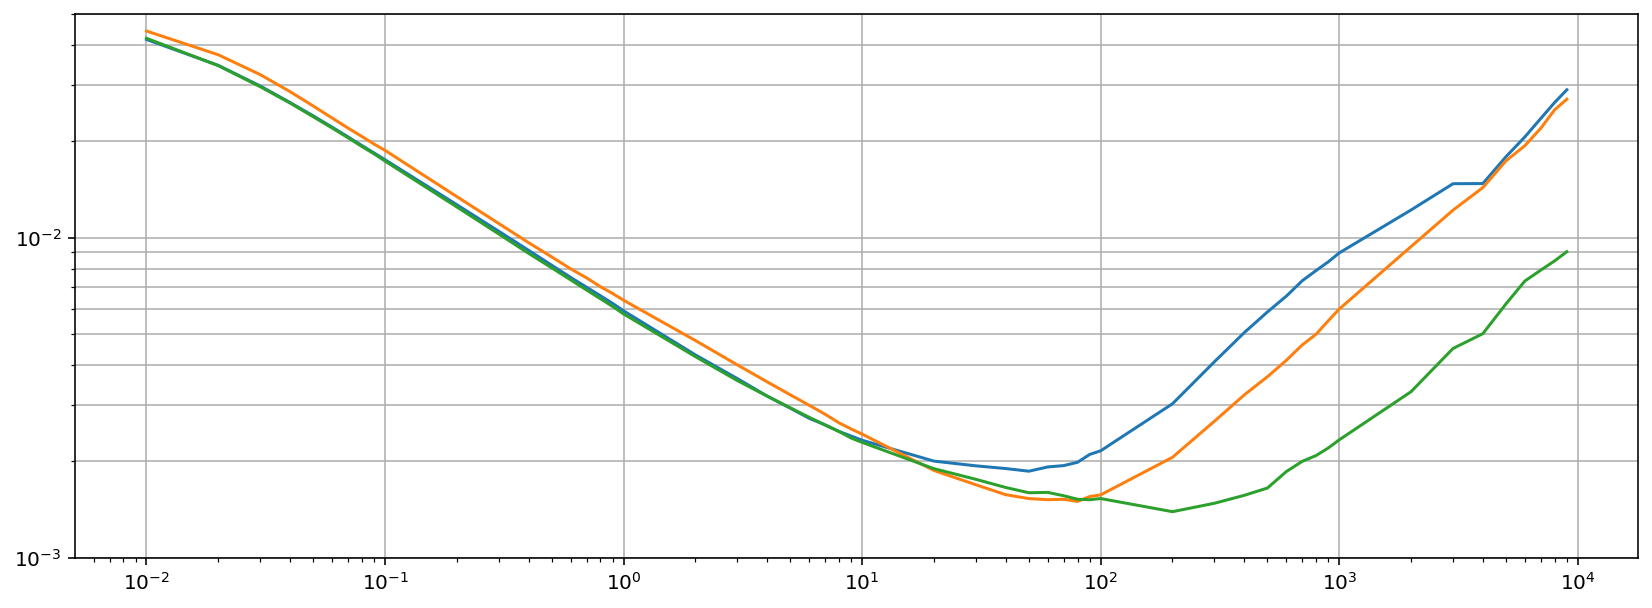

In [9]:
avargx_real, tau_real = allan_var(data[:, 3], 100)
avargy_real, tau_real = allan_var(data[:, 4], 100)
avargz_real, tau_real = allan_var(data[:, 5], 100)

fig, ax = plt.subplots(1, 1, figsize = (14, 5))
ax.loglog(tau_real, np.sqrt(avargx_real), '-')
ax.loglog(tau_real, np.sqrt(avargy_real), '-')
ax.loglog(tau_real, np.sqrt(avargz_real), '-')
ax.grid("on", "both", "y")
ax.grid("on", "major", "x")
ax.set_ylim([10**(-3), 5 * 10**(-2)])
plt.show()

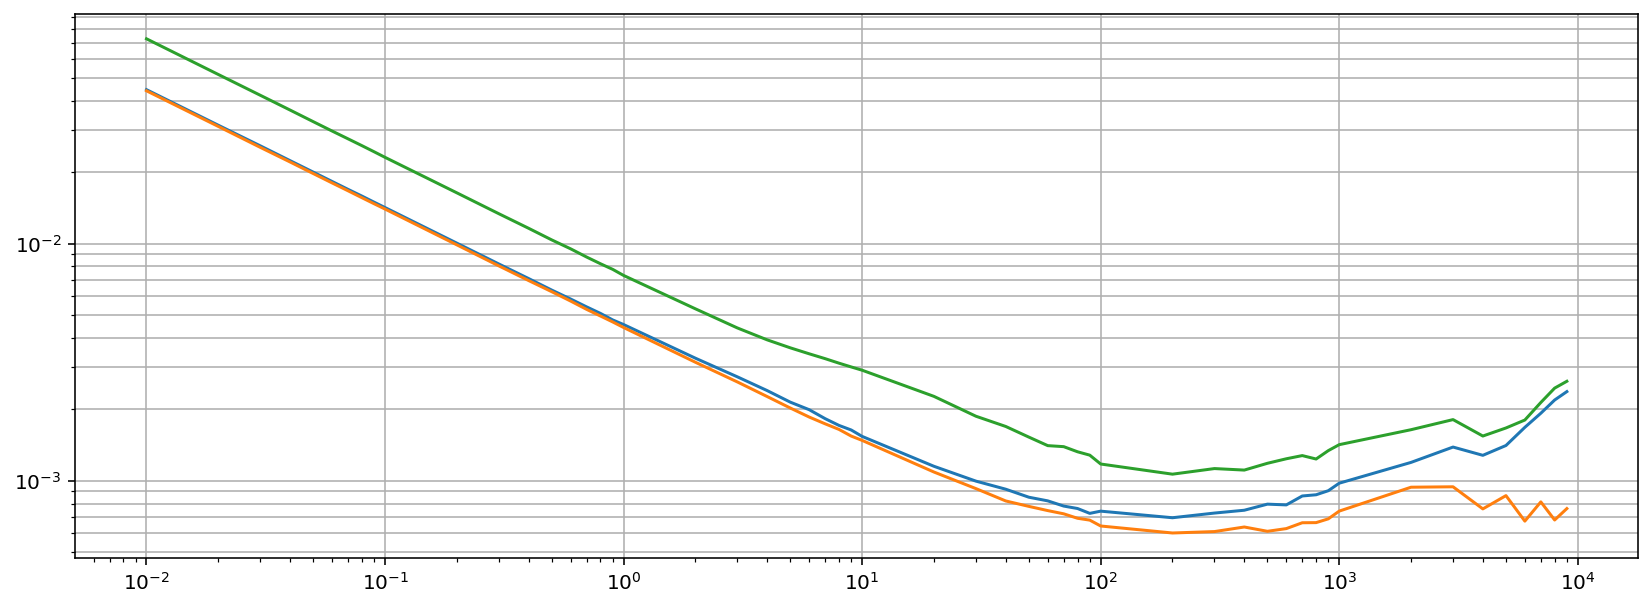

In [10]:
avarax_real, tau_real = allan_var((data[:, 0] - data[0, 0]) * 9.81, 100)
avaray_real, tau_real = allan_var((data[:, 1] - data[0, 1]) * 9.81, 100)
avaraz_real, tau_real = allan_var((data[:, 2] - data[0, 2]) * 9.81, 100)

fig, ax = plt.subplots(1, 1, figsize = (14, 5))
ax.loglog(tau_real, np.sqrt(avarax_real), '-')
ax.loglog(tau_real, np.sqrt(avaray_real), '-')
ax.loglog(tau_real, np.sqrt(avaraz_real), '-')
ax.grid("on", "both", "y")
ax.grid("on", "major", "x")
# ax.set_ylim([10**(-3), 5 * 10**(-2)])
plt.show()

In [29]:
import math

D2R = np.deg2rad(1.0)

gyr_params = {'b': np.array([0.1, 0.2, 0.7]) * D2R,
              'b_drift': np.array([5.4**2, 5.4**2, 5.4**2]) * D2R/3600.0,
              'b_corr':np.array([800.0, 800.0, 800.0]),
              'arw': np.array([0.36, 0.36, 0.36]) * D2R/60.0,
              'E_true': np.array([0.02, -0.03, -0.015, 0.025, 0.015, 0.005]),
              'E_found': np.array([0.01959926, -0.03032111, -0.01620291, 0.02518113, 0.01537294, 0.00529229]),
              'gyr_to_acc_true': np.deg2rad([0.3, 2.5, -1.7]),
              'gyr_to_acc_found': np.array([0.00532557, 0.04387996, -0.02940817])}

gps_params = {'stdp': np.array([3.0, 3.0, 5.0]), 'delay':0.0}

odo_params = {'scale': 1.02,
              'stdv': 0.1}

N = 100 * 60 * 60 * 24
fs = 100
dt = 0.01
gyr_true = np.zeros((N, 3))

def bias_drift(corr_time, drift, n, fs):
    """
    Bias drift (instability) model for accelerometers or gyroscope.
    If correlation time is valid (positive and finite), a first-order Gauss-Markov model is used.
    Otherwise, a simple normal distribution model is used.
    Args:
        corr_time: 3x1 correlation time, sec.
        drift: 3x1 bias drift std, rad/s.
        n: total data count
        fs: sample frequency, Hz.
    Returns
        sensor_bias_drift: drift of sensor bias
    """
    # 3 axis
    sensor_bias_drift = np.zeros((n, 3))
    for i in range(0, 3):
        if not np.isinf(corr_time[i]):
            # First-order Gauss-Markov
            a = 1 - 1/fs/corr_time[i]
#             a = np.sqrt(np.exp(1/fs/corr_time[i]))
            # For the following equation, see issue #19 and
            # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3812568/ (Eq. 3).
            b = drift[i] * np.sqrt(1.0 - np.exp(-2/(fs * corr_time[i])))
#             b = 1/fs*drift[i] 
            drift_noise = np.random.randn(n, 3)
            for j in range(1, n):
                sensor_bias_drift[j, i] = a*sensor_bias_drift[j-1, i] + b*drift_noise[j-1, i]
        else:
            # normal distribution
            sensor_bias_drift[:, i] = drift[i] * np.random.randn(n)
    return sensor_bias_drift

gyr_bias = gyr_params['b']
gyr_bias_drift = bias_drift(gyr_params['b_corr'], gyr_params['b_drift'], N, fs)
gyr_noise = gyr_params['arw'] / np.sqrt(dt) * np.random.randn(N, 3)
    
gyr_measured = np.rad2deg(gyr_true + gyr_bias + gyr_bias_drift + gyr_noise)

## Gyro

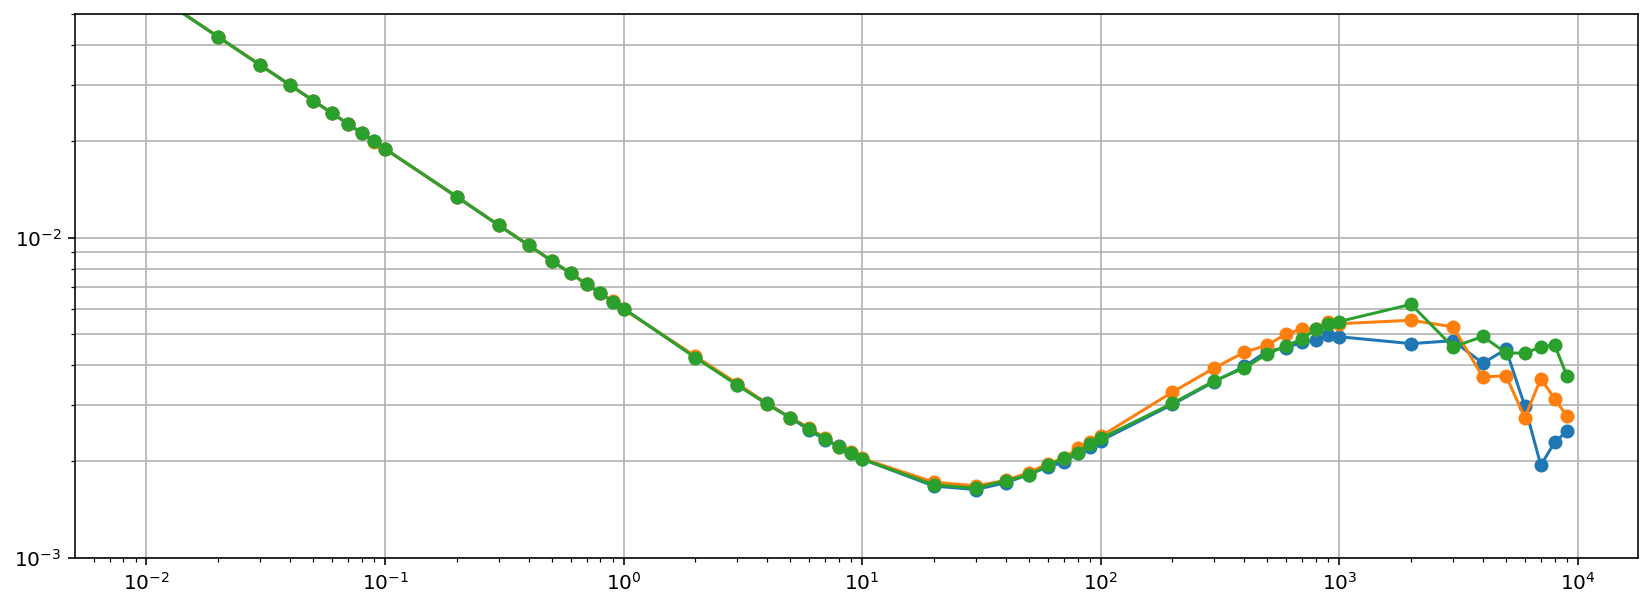

In [30]:
avargx, taug = allan_var(gyr_measured[:, 0], 100)
avargy, taug = allan_var(gyr_measured[:, 1], 100)
avargz, taug = allan_var(gyr_measured[:, 2], 100)

fig, ax = plt.subplots(1, 1, figsize = (14, 5))
ax.loglog(taug, np.sqrt(avargx), '-o')
ax.loglog(taug, np.sqrt(avargy), '-o')
ax.loglog(taug, np.sqrt(avargz), '-o')
ax.grid("on", "both", "y")
ax.grid("on", "major", "x")
ax.set_ylim([10**(-3), 5 * 10**(-2)])
plt.show()

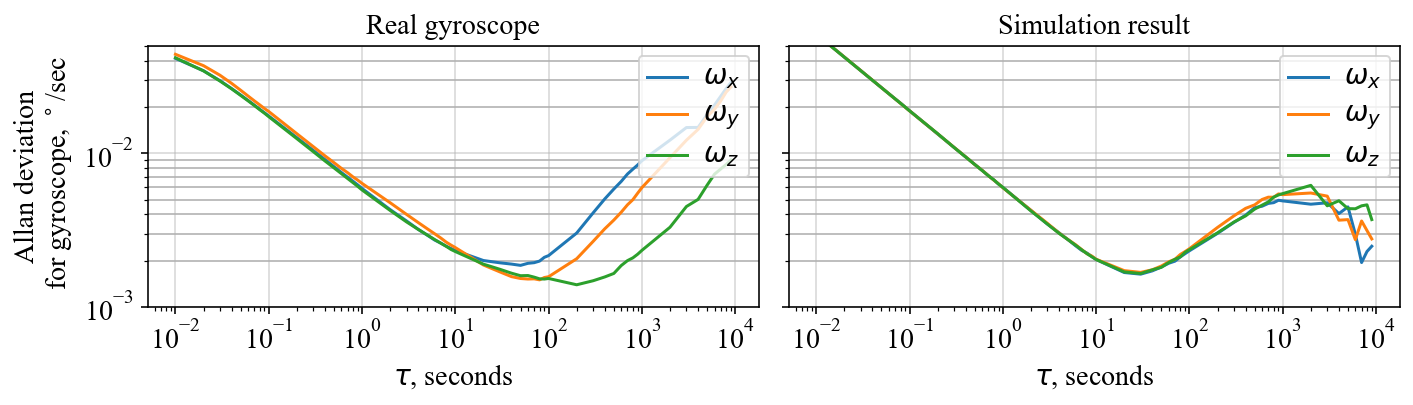

In [31]:
fig, axes = plt.subplots(1, 2, figsize = (10, 3), sharey=True)
ax = axes[0]
ax.loglog(tau_real, np.sqrt(avargx_real), '-')
ax.loglog(tau_real, np.sqrt(avargy_real), '-')
ax.loglog(tau_real, np.sqrt(avargz_real), '-')
ax.grid("on", "both", "y")
ax.grid("on", "major", "x")
ax.set_ylim([10**(-3), 5 * 10**(-2)])
# ax.set(xlabel='$\\tau$, с', ylabel='Девиация Аллана\n для гироскопа, $^\circ$/с')
# ax.set_title("Действительный гироскоп")

ax.set(xlabel='$\\tau$, seconds', ylabel='Allan deviation\n for gyroscope, $^\circ$/sec')
ax.set_title("Real gyroscope")

ax = axes[1]
ax.loglog(taug, np.sqrt(avargx), '-', label='x')
ax.loglog(taug, np.sqrt(avargy), '-', label='y')
ax.loglog(taug, np.sqrt(avargz), '-', label='z')
ax.grid("on", "both", "y")
ax.grid("on", "major", "x")
# ax.set_ylim([10**(-3), 5 * 10**(-2)])
ax.set(xlabel='$\\tau$, seconds')
ax.set_title("Simulation result")


axes[0].legend(['$\omega_x$', '$\omega_y$', '$\omega_z$'], loc = 'upper right')
axes[1].legend(['$\omega_x$', '$\omega_y$', '$\omega_z$'], loc = 'upper right')
for a in axes:
    a.grid(which='major', alpha=0.5)
    for item in ([a.title, a.xaxis.label, a.yaxis.label] +
                  a.get_xticklabels() + a.get_yticklabels() + a.get_legend().get_texts()):
        item.set_fontsize(14)
        item.set_fontname('Times New Roman')

plt.tight_layout()


plt.savefig("gyr_allan_real_vs_imitator_en.pdf", bbox_inches='tight')

plt.show()

## Accel

In [16]:
# acc_params = {'b': np.array([0.1, 0.3, -0.2]),
#               'b_drift': np.array([0.0012, 0.0012, 0.0012]),
#               'b_corr': np.array([600.0, 600.0, 600.0]),
#               'vrw': np.array([0.28, 0.28, 0.28]) / 60.0,
#               'E_true': np.array([0.01, 0.02, 0.025, -0.02, 0.005, 0.01]),
#               'E_found': np.array([0.01041845, 0.02038139, 0.025365, -0.01981064, 0.00462204, 0.01016331])}

# def bias_drift(corr_time, drift, n, fs):
#     sensor_bias_drift = np.zeros((n, 3))
#     for i in range(0, 3):
#         if not np.isinf(corr_time[i]):
#             # First-order Gauss-Markov
#             a = 1 - 1/fs/corr_time[i]
#             # For the following equation, see issue #19 and
#             b = drift[i] * np.sqrt(1.0 - np.exp(-2/(fs * corr_time[i])))
# #             b = 1/fs*drift[i] 
#             drift_noise = np.random.randn(n, 3)
#             for j in range(1, n):
#                 sensor_bias_drift[j, i] = a*sensor_bias_drift[j-1, i] + b*drift_noise[j-1, i]
#         else:
#             # normal distribution
#             sensor_bias_drift[:, i] = drift[i] * np.random.randn(n)
#     return sensor_bias_drift


# acc_true = np.zeros((N, 3))

# acc_bias = acc_params['b']
# acc_bias_drift = bias_drift(acc_params['b_corr'], acc_params['b_drift'], N, fs)
# acc_noise = acc_params['vrw'] / np.sqrt(dt) * np.random.randn(N, 3)
    
# acc_measured = (acc_true + acc_bias + acc_bias_drift + acc_noise)

# avarax, taua = allan_var(acc_measured[:, 0], 100)
# avaray, taua = allan_var(acc_measured[:, 1], 100)
# avaraz, taua = allan_var(acc_measured[:, 2], 100)

In [17]:
# fig, axes = plt.subplots(1, 2, figsize = (10, 3), sharey=True)
# ax = axes[0]
# ax.loglog(tau_real, np.sqrt(avarax_real), '-')
# ax.loglog(tau_real, np.sqrt(avaray_real), '-')
# ax.loglog(tau_real, np.sqrt(avaraz_real), '-')
# ax.grid("on", "both", "y")
# ax.grid("on", "major", "x")
# ax.set(xlabel='$\\tau$, с', ylabel='Девиация Аллана\n для акселерометра, м/с$^2$')
# ax.set_title("Действительный акселерометр")

# ax = axes[1]
# ax.loglog(taua, np.sqrt(avarax), '-', label='x')
# ax.loglog(taua, np.sqrt(avaray), '-', label='y')
# ax.loglog(taua, np.sqrt(avaraz), '-', label='z')
# ax.grid("on", "both", "y")
# ax.grid("on", "major", "x")
# ax.set(xlabel='$\\tau$, с')
# ax.set_title("Результат симуляции")


# axes[0].legend(['$a_x$', '$a_y$', '$a_z$'], loc = 'upper right')
# axes[1].legend(['$a_x$', '$a_y$', '$a_z$'], loc = 'upper right')
# for a in axes:
#     a.grid(which='major', alpha=0.5)
#     for item in ([a.title, a.xaxis.label, a.yaxis.label] +
#                   a.get_xticklabels() + a.get_yticklabels() + a.get_legend().get_texts()):
#         item.set_fontsize(14)
#         item.set_fontname('Times New Roman')

# plt.tight_layout()


# plt.savefig("acc_allan_real_vs_imitator.pdf", bbox_inches='tight')

# plt.show()

# Visualize null-test

In [37]:
def plot_simdata(sim, simdata, filepath=None):
    matplotlib.interactive(False)
    fig, axes = plt.subplots(4, 1, figsize=(15, 24), gridspec_kw={'height_ratios': [3, 1, 1, 1]})
    ax = axes[0]
    l1, l2 = ax.plot(simdata['ned_positions'][:,1], simdata['ned_positions'][:,0], '-', 
                      sim.position_points[:,1], sim.position_points[:,0], 'o-')
    l1.axes.set_aspect('equal')
    l2.axes.set_title('Waypoints for N-Point example')
    ax.axis("equal")

    ax = axes[1]
    ax.plot(simdata['times'], simdata['ned_velocities'], '-')
    ax.legend(['Velocity East', 'Velocity North', "Velocity up"], loc='upper right')

    ax = axes[2]
    localVelocities = []
    for r_, v_ in zip(simdata['body2ned_rotations'].as_matrix(), simdata['ned_velocities']):
        localVelocities.append(r_.T @ v_)
    ax.plot(simdata['times'], localVelocities)
    ax.legend(['V_x body', 'V_y body', 'V_z body'], loc='upper right')

    ax = axes[3]
    eulers = simdata['body2ned_rotations'].inv().as_euler('zyx', degrees=False)
    ax.plot(sim.times, np.rad2deg(eulers))
    ax.legend(["yaw", "pitch", "roll"], loc='upper right')

    if filepath:
        plt.savefig(filepath)
        plt.close()
        
def plot_route(route, graph, save=False, filepath=None, ax = None, route_color = 'red', figsize = (8, 8)):
    matplotlib.interactive(False)
    points = np.array([[graph.nodes[p]['x'], graph.nodes[p]['y']] for p in route])
    bbox = (np.max(points[:, 1]), np.min(points[:, 1]), np.max(points[:, 0]), np.min(points[:, 0]))
    bbox_tl = np.max(points[:, 1]), np.min(points[:, 0])
    bbox_br = np.min(points[:, 1]), np.max(points[:, 0])

    bbox_center = np.mean(bbox[0:2]), np.mean(bbox[2:4])

    max_distance = np.max([geopy.distance.distance(bbox_center, bbox_tl).m,
                           geopy.distance.distance(bbox_center, bbox_br).m])
    
    bbox = ox.utils_geo.bbox_from_point(bbox_center, dist=max_distance)
    
    route_n_edges = []
    for n in route:
        route_n_edges.append(len(G.adj[n]))
    
    route_and_n_edges = np.vstack((route, route_n_edges)).T
    if save and filepath is not None:
        fp = filepath + '.png'
        np.savetxt(filepath + '.txt', route_and_n_edges, fmt='%i')
    else:
        fp = ''
    fig = None
    if ax is None:
        fig, ax = ox.plot_graph_route(G, route, route_linewidth=2, node_size=5, node_color='g', bgcolor='w', bbox=bbox,
                                 show=False, close=False, dpi = 400, route_color = route_color, route_alpha = 0.8, figsize = figsize)
    else:
        ox.plot_graph_route(G, route, route_linewidth=2, node_size=5, node_color='g', bgcolor='w',
                            show=False, close=False, bbox=bbox, ax=ax, route_color = route_color, route_alpha = 0.8, figsize = figsize)
    
    return fig, ax

In [44]:
gyr_params = {'b': np.array([0.1, 0.2, 0.7]) * D2R,
              'b_drift': np.array([5.4**2, 5.4**2, 5.4**2]) * D2R/3600.0,
              'b_corr':np.array([100.0, 100.0, 100.0]),
              'arw': np.array([0.36, 0.36, 0.36]) * D2R/60.0,
              'E_true': np.array([0.02, -0.03, -0.015, 0.025, 0.015, 0.005]),
              'E_found': np.array([0.01959926, -0.03032111, -0.01620291, 0.02518113, 0.01537294, 0.00529229]),
              'gyr_to_acc_true': np.deg2rad([0.3, 2.5, -1.7]),
              'gyr_to_acc_found': np.array([0.00532557, 0.04387996, -0.02940817])}

acc_params = {'b': np.array([0.1, 0.3, -0.2]),
              'b_drift': np.array([0.0006**2, 0.0006**2, 0.0006**2]),
              'b_corr': np.array([100.0, 100.0, 100.0]),
              'vrw': np.array([0.28, 0.28, 0.28]) / 60.0,
              'E_true': np.array([0.01, 0.02, 0.025, -0.02, 0.005, 0.01]),
              'E_found': np.array([0.01041845, 0.02038139, 0.025365, -0.01981064, 0.00462204, 0.01016331])}

gps_params = {'stdp': np.array([3.0, 3.0, 5.0]), 'delay':0.0}

odo_params = {'scale': 1.02,
              'stdv': 0.1}

MIN_TRAVEL_TIME = 80
dataset_number = 1
np.random.seed(122)
while True:
    try:
        fromPoint, toPoint = np.random.choice(list(G.nodes())), np.random.choice(list(G.nodes()))
        while (nx.shortest_path_length(G, fromPoint, toPoint, weight='travel_time') > MIN_TRAVEL_TIME):
            fromPoint, toPoint = np.random.choice(list(G.nodes())), np.random.choice(list(G.nodes()))

        travel_time = nx.shortest_path_length(G, fromPoint, toPoint, weight='travel_time')
        route = nx.shortest_path(G, fromPoint, toPoint, weight='travel_time')
        route_length = nx.path_weight(G, route, weight='length')

        nodes, edges = ox.graph_to_gdfs(G)
        geoms = [edges.loc[(u, v, 0), 'geometry'] for u, v in zip(route[:-1], route[1:])]
        lonlat_points = []
        for ls in geoms:
            for p in ls.coords:
                lonlat_points.append([p[0], p[1]])

        ned_points_orig = generate_ned_points_from_lonlat_sequence(lonlat_points)
        ned_points = resample_ned_points(ned_points_orig, segment_len = 30.0)
        times = generate_times_for_ned_path_segments(ned_points, avg_motion_speed = 11.0)

        sim = Simulation(times, ned_points, in_convention = 'ned', out_convention = 'ned')
        simdata = sim.data()

        lon_start, lat_start, h_start = lonlat_points[0][0], lonlat_points[0][1], 0.0
        kinNed = EarthInducedKinematics(lat_start, lon_start, h_start, simdata)
        kinNed.updateSimulatedData()

        acc_measured, acc_bias_drift, acc_decalibr, acc_calibr = gen_accel_measurements_with_errors(simdata, acc_params)
        simdata['acc_measured'] = acc_measured
        simdata['acc_bias_drift'] = acc_bias_drift
        simdata['acc_decalibrated'] = acc_decalibr
        simdata['acc_calibrated'] = acc_calibr

        gyr_measured, gyr_bias_drift, gyr_decalibr, gyr_calibr = gen_gyro_measurements_with_errors(simdata, gyr_params)
        simdata['gyr_measured'] = gyr_measured
        simdata['gyr_bias_drift'] = gyr_bias_drift
        simdata['gyr_decalibrated'] = gyr_decalibr
        simdata['gyr_calibrated'] = gyr_calibr

        simdata['odo_measured'] = gen_odometer_measurements_with_errors(simdata, odo_params)
        simdata['gps_measured'] = gen_gps_measurements_with_errors(simdata, gps_params)
        simdata['sensor_errors'] = {'gyroscope':gyr_params, 'accelerometer':acc_params,
                                 'odometer':odo_params, 'gps':gps_params}

        path = os.path.join(DATA_OUT_FOLDER, f'{dataset_number:06}')
        os.mkdir(path)
        plot_route(route, G, save = True, filepath = os.path.join(path, 'route'))
        np.savetxt(os.path.join(path, 'routelength_exptraveltime_numsegment_time.txt'), [route_length, travel_time, len(route), times[-1]], fmt='%.3f')
        np.savetxt(os.path.join(path, 'route_latlon.txt'), np.array(lonlat_points)[:,::-1], fmt='%.10f')

        plot_simdata(sim, simdata, os.path.join(path, 'simulated_data.png'))
        pickle.dump(simdata, open(os.path.join(path, 'simdata.p'), 'wb'))

        to_log_csv(simdata, os.path.join(path, 'data_ideal.log'), out_names = {
            'times':'times', 'acc':'body_accelerations_with_earth', 'gyr':'body_angular_rates_with_earth',
            'odo':'odometer', 'llh':'geodetic_positions', 'azi':'body2ned_rotations'
        })


        to_log_csv(simdata, os.path.join(path, 'data.log'), out_names = {
            'times':'times', 'acc':'acc_measured', 'gyr':'gyr_measured',
            'odo':'odo_measured', 'llh':'gps_measured', 'azi':'body2ned_rotations'
        })

        to_log_csv(simdata, os.path.join(path, 'data_decalibrated.log'), out_names = {
            'times':'times', 'acc':'acc_decalibrated', 'gyr':'gyr_decalibrated',
            'odo':'odo_measured', 'llh':'gps_measured', 'azi':'body2ned_rotations'
        })

        to_log_csv(simdata, os.path.join(path, 'data_calibrated.log'), out_names = {
            'times':'times', 'acc':'acc_calibrated', 'gyr':'gyr_calibrated',
            'odo':'odo_measured', 'llh':'gps_measured', 'azi':'body2ned_rotations'
        })

        shutil.copy('config.csv', os.path.join(path, 'config.csv'))
    except Exception as e:
        print("***\nFailed to generate log number: ", dataset_number, "\n***")
        logging.error(traceback.format_exc())
    else:
        print("Log generated: ", dataset_number)
        break

<ipython-input-3-bea4cedf67d3>:181: RuntimeWarning: invalid value encountered in arccos
  tmp = np.arccos(0.5 * (R_old_new[0, 0] + R_old_new[1, 1] + R_old_new[2, 2] - 1.0))


Log generated:  1
